In [1]:
%load_ext autotime

time: 150 µs (started: 2022-01-25 16:26:18 +01:00)


In [2]:
import pytorch_lightning as pl
from torch.nn import functional as F
from torch import nn
import torch
from pytorch_lightning.callbacks import LearningRateMonitor

time: 1.09 s (started: 2022-01-25 16:26:19 +01:00)


In [3]:
import numpy as np

import glob

training_data_files = glob.glob("/home/aaron/projects/ghost/data/spike_in/chromatograms/AAS_P2009_167.npz")

time: 355 µs (started: 2022-01-25 16:26:43 +01:00)


In [4]:
chrom_tensors = []
label_tensors = []
# score_tensors = []

for training_data_file in training_data_files:

    chrom_training_data_file = np.load(training_data_file)

    chromatograms = chrom_training_data_file["chromatograms"]

    labels = chrom_training_data_file["labels"]

    chrom_tensors.append(chromatograms)
    label_tensors.append(labels)

    # chrom_tensors.append(
    #     torch.from_numpy(chrom_training_data_file["chromatograms"]).type(torch.FloatTensor)
    # )
#     label_tensors.append(
#         torch.from_numpy(chrom_training_data_file["labels"]).type(torch.FloatTensor)
#     )
#
#     score_tensors.append(
#         torch.from_numpy(chrom_training_data_file["scores"]).type(torch.FloatTensor)
#     )
#
chrom_tensors = np.concatenate(chrom_tensors, axis=0)
label_tensors =  np.concatenate(label_tensors, axis=0)
# score_tensors = torch.cat(score_tensors, 0)
chrom_tensors.shape, label_tensors.shape

((40111, 1, 6, 25), (40111, 1))

time: 60.1 ms (started: 2022-01-25 16:26:43 +01:00)


In [5]:
from gscore.models.deep_chromatogram_classifier import DeepChromScorer

time: 170 ms (started: 2022-01-25 16:26:47 +01:00)


In [6]:
model = DeepChromScorer(
    max_epochs=1,
    gpus=1,
    threads=10
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


time: 103 ms (started: 2022-01-25 16:26:48 +01:00)


In [7]:
# model.fit(data=chrom_tensors, labels=label_tensors)

time: 172 µs (started: 2022-01-25 16:26:51 +01:00)


In [8]:
# model.save(model_path="test_wrapper.model")

time: 145 µs (started: 2022-01-25 16:26:55 +01:00)


In [9]:
# model.evaluate(data=chrom_tensors, labels=label_tensors)

time: 175 µs (started: 2022-01-25 16:26:58 +01:00)


In [10]:
model.load("/home/aaron/projects/ghost/data/spike_in/testing-cli.model")

time: 33.5 ms (started: 2022-01-25 16:27:28 +01:00)


In [11]:
scores = model.score(data=chrom_tensors)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/home/aaron/miniconda3/envs/ghostdev/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:172: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


time: 4.04 s (started: 2022-01-25 16:27:33 +01:00)


In [12]:
import pandas as pd
import seaborn as sns

scores_df = pd.DataFrame(
    {
        "score": scores.reshape(-1),
        "label": label_tensors.reshape(-1)
    }
)

time: 138 ms (started: 2022-01-25 16:27:40 +01:00)


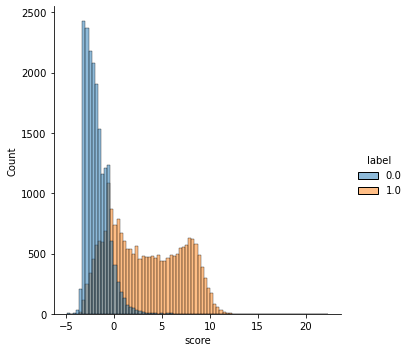

time: 509 ms (started: 2022-01-25 16:27:50 +01:00)


In [13]:
sns.displot(scores_df, x="score", hue="label")

In [6]:
from torch.utils.data import TensorDataset, DataLoader

time: 254 µs (started: 2022-01-24 15:22:26 +01:00)


In [7]:
chrom_dataset = TensorDataset(chrom_tensors, label_tensors)

time: 233 µs (started: 2022-01-24 15:22:28 +01:00)


In [8]:
train_length = int(0.7* len(chrom_dataset))

test_length = len(chrom_dataset) - train_length

train_dataset, test_dataset = torch.utils.data.random_split(
    chrom_dataset,
    (train_length, test_length)
)

time: 2.48 ms (started: 2022-01-24 15:22:28 +01:00)


In [9]:
validation_length = int(0.1 * len(train_dataset))
validation_length

2491

time: 1.49 ms (started: 2022-01-24 15:22:29 +01:00)


In [10]:
train_length = len(train_dataset) - validation_length
train_length

22419

time: 2.54 ms (started: 2022-01-24 15:22:29 +01:00)


In [11]:
train_dataset, validation_dataset = torch.utils.data.random_split(
    train_dataset,
    (train_length, validation_length)
)

time: 2.27 ms (started: 2022-01-24 15:22:29 +01:00)


In [12]:
chrom_dataloader = DataLoader(
    train_dataset,
    batch_size=100,
    shuffle=True,
    num_workers=10
)

time: 1.08 ms (started: 2022-01-24 15:22:30 +01:00)


In [13]:
validation_dataloader = DataLoader(
    validation_dataset,
    batch_size=100,
    num_workers=10
)

time: 325 µs (started: 2022-01-24 15:22:30 +01:00)


In [14]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=100,
    num_workers=10
)

time: 317 µs (started: 2022-01-24 15:22:30 +01:00)


In [15]:
from torch.optim.lr_scheduler import ReduceLROnPlateau


class DeepChromModel(pl.LightningModule):

    def __init__(self, learning_rate=0.0005):

        self.lr = learning_rate

        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=10,
                kernel_size=5,
                padding="same",
            ), nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=1
            ),
            nn.Conv2d(
                10, 42,
                kernel_size=5,
                padding="same",
            ), nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2
            ),
            nn.BatchNorm2d(42),
            nn.Flatten()
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(1008, 1008), nn.ReLU(),
            nn.BatchNorm1d(1008),
            nn.Linear(1008, 1008), nn.ReLU(),
            nn.Linear(1008, 1)
        )

    def configure_optimizers(self):

        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=(self.lr or self.learning_rate)
        )

        scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=5, min_lr=1e-6)

        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "train_loss"
        }

    def training_step(self, batch, batch_idx):

        chromatograms, labels = batch

        y_hat = self(chromatograms)

        loss = F.binary_cross_entropy_with_logits(
            y_hat,
            labels
        )

        self.log(
            "train_loss",
            loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True
        )

        return loss

    def validation_step(self, batch, batch_idx):

        chromatograms, labels = batch

        y_hat = self(chromatograms)

        loss = F.binary_cross_entropy_with_logits(
            y_hat,
            labels
        )

        return loss

    def test_step(self, batch, batch_idx):

        chromatograms, labels = batch

        y_hat = self(chromatograms)

        loss = F.binary_cross_entropy_with_logits(
            y_hat,
            labels
        )

        labels_hat = torch.argmax(y_hat, dim=1)

        accuracy = torch.sum(labels_hat == labels).item() / (len(labels) * 1.0)

        self.log_dict({
            'test_loss': loss,
            'test_acc': accuracy,
        })

    def predict_step(self, batch, batch_idx, dataloader_idx=0):

        chromatograms, = batch

        return self(chromatograms)

    def forward(self, chromatogram):

        out = self.conv_layers(chromatogram)

        out = self.linear_layers(out)

        return out

time: 1.32 ms (started: 2022-01-24 15:22:30 +01:00)


In [16]:
model = DeepChromModel()

time: 19.3 ms (started: 2022-01-24 14:33:57 +01:00)


In [17]:
model.conv_layers(chrom_tensors[0].reshape(1, 1, 6, 25)).shape

torch.Size([1, 1008])

time: 3.41 ms (started: 2022-01-24 14:33:58 +01:00)


In [18]:
lr_monitor = LearningRateMonitor(logging_interval="epoch")

time: 382 µs (started: 2022-01-24 14:33:58 +01:00)


In [21]:
from pytorch_lightning.callbacks import EarlyStopping

early_stop_callback = EarlyStopping(

   monitor='train_loss',

   min_delta=0.00,

   patience=10,

   verbose=True,

   mode='min'
)

time: 318 µs (started: 2022-01-24 14:34:08 +01:00)


In [22]:
trainer = pl.Trainer(
    max_epochs=1000,
    gpus=1,
    callbacks=[
        lr_monitor,
        early_stop_callback
    ]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


time: 71.1 ms (started: 2022-01-24 14:34:09 +01:00)


In [23]:
trainer.fit(
    model,
    train_dataloaders=chrom_dataloader,
    val_dataloaders=validation_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | conv_layers   | Sequential | 10.9 K
1 | linear_layers | Sequential | 2.0 M 
---------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.192     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.170


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.040 >= min_delta = 0.0. New best score: 0.130


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.119


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.113


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.110


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.103


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.097


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.096


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.090


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.089


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.081


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.077


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.074


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.071


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.063


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.060


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.058


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.053


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.046


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.041


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.039


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.034


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.033


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.032


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.030


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.025


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.024


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.018


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.015


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.012


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.007


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.005


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.004


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.003


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric train_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric train_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


time: 5min 49s (started: 2022-01-24 14:34:10 +01:00)


In [24]:
trainer.test(dataloaders=test_dataloader)

/home/aaron/miniconda3/envs/ghostdev/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1394: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at /home/aaron/projects/gscorer/gscore/notebooks/lightning_logs/version_84/checkpoints/epoch=101-step=22949.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /home/aaron/projects/gscorer/gscore/notebooks/lightning_logs/version_84/checkpoints/epoch=101-step=22949.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 50.739227294921875, 'test_loss': 0.46606606245040894}
--------------------------------------------------------------------------------


[{'test_loss': 0.46606606245040894, 'test_acc': 50.739227294921875}]

time: 803 ms (started: 2022-01-24 15:05:36 +01:00)


In [25]:
trainer.save_checkpoint(
    "test.model"
)

time: 47.9 ms (started: 2022-01-24 15:05:54 +01:00)


In [16]:
model = DeepChromModel.load_from_checkpoint(
    checkpoint_path="test.model"
)

time: 28.4 ms (started: 2022-01-24 15:22:40 +01:00)


In [17]:
trainer = pl.Trainer(gpus=1)

pred_dataset = TensorDataset(
    chrom_tensors
)

pred_dataloader = DataLoader(
    pred_dataset,
    num_workers=10,
    batch_size=10000

)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


time: 67.4 ms (started: 2022-01-24 15:22:42 +01:00)


In [18]:
predictions = trainer.predict(
    model,
    dataloaders=pred_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/home/aaron/miniconda3/envs/ghostdev/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:172: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


time: 4.15 s (started: 2022-01-24 15:22:48 +01:00)


In [19]:
predictions = torch.cat(predictions, 0).numpy()

time: 803 µs (started: 2022-01-24 15:22:55 +01:00)


In [20]:
import seaborn as sns
import pandas as pd

time: 259 ms (started: 2022-01-24 15:22:56 +01:00)


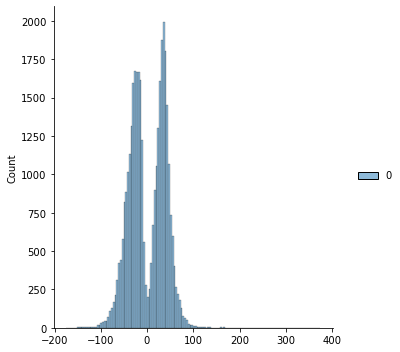

time: 440 ms (started: 2022-01-24 15:22:57 +01:00)


In [21]:
sns.displot(predictions)

In [22]:
predictions.shape

(35586, 1)

time: 1.13 ms (started: 2022-01-24 15:22:59 +01:00)


In [23]:
score_comparisons = pd.DataFrame(
    {
        "label": label_tensors.numpy().reshape(-1),
        "de_noising_score": score_tensors.numpy().reshape(-1),
        "prediction":predictions.reshape(-1)
    }
)

time: 2.25 ms (started: 2022-01-24 15:22:59 +01:00)


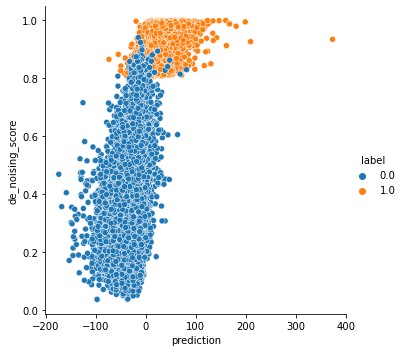

time: 1.57 s (started: 2022-01-24 15:23:00 +01:00)


In [24]:
sns.relplot(data=score_comparisons, x="prediction", y="de_noising_score", hue="label")

In [25]:
torch.sigmoid(torch.tensor(predictions[3])), label_tensors[3], score_tensors[3]

(tensor([1.]), tensor([1.]), tensor([0.8968]))

time: 4.46 ms (started: 2022-01-24 15:23:03 +01:00)


In [26]:
test = pd.DataFrame(
    chrom_tensors[0].reshape(6, 25).T.numpy()
)

time: 666 µs (started: 2022-01-24 15:23:04 +01:00)


In [27]:
test = test.reset_index()
test

,index,0,1,2,3,4,5
0,0,0.056897,0.000000,0.000000,0.032894,0.000000,0.000000
1,1,0.026552,0.000000,0.034782,0.053875,0.000000,0.292272
2,2,0.004568,0.000000,0.072071,0.076747,0.019344,0.554358
3,3,0.041115,0.000000,0.126916,0.112859,0.174093,0.605146
4,4,0.082443,0.051893,0.188101,0.156045,0.302232,0.654487
5,5,0.134740,0.222836,0.263829,0.215458,0.369324,0.700506
6,6,0.191018,0.361579,0.342207,0.261192,0.447120,0.744333
7,7,0.252605,0.457388,0.424117,0.288687,0.539186,0.785239
8,8,0.281280,0.494057,0.511089,0.370948,0.614415,0.874225
9,9,0.288658,0.492460,0.601334,0.488645,0.678748,0.994321


time: 20.4 ms (started: 2022-01-24 15:23:04 +01:00)


In [28]:
melted_test = test.melt(id_vars="index")
melted_test

,index,variable,value
0,0,0,0.056897
1,1,0,0.026552
2,2,0,0.004568
3,3,0,0.041115
4,4,0,0.082443
...,...,...,...
145,20,5,0.210837
146,21,5,0.194122
147,22,5,0.161627
148,23,5,0.184671


time: 12 ms (started: 2022-01-24 15:23:05 +01:00)


<AxesSubplot:xlabel='index', ylabel='value'>

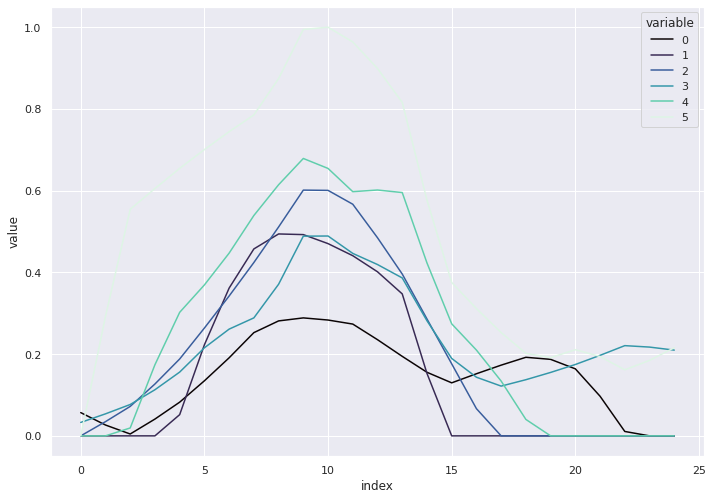

time: 200 ms (started: 2022-01-24 15:23:06 +01:00)


In [29]:
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=melted_test, x="index", y="value", hue="variable", palette="mako")

In [30]:
from gscore.parsers import sqmass
from gscore.parsers.osw import OSWFile
from gscore.parsers import queries

time: 170 ms (started: 2022-01-24 15:23:12 +01:00)


In [31]:
sqmass_file_path = "/home/aaron/projects/ghost/data/spike_in/chromatograms/AAS_P2009_167.sqMass"
osw_file_path = "/home/aaron/projects/ghost/data/spike_in/openswath/AAS_P2009_167.osw"

time: 290 µs (started: 2022-01-24 15:23:12 +01:00)


In [32]:
with sqmass.SqMassFile(sqmass_file_path) as sqmass_file:

    chromatograms = sqmass_file.parse()

time: 45.9 s (started: 2022-01-24 15:23:12 +01:00)


In [33]:
with OSWFile(osw_file_path) as osw_file:

    precursors = osw_file.parse_to_precursors(
        query=queries.SelectPeakGroups.FETCH_CHROMATOGRAM_TRAINING_RECORDS
    )

Cleaning unused score columns.
time: 13.5 s (started: 2022-01-24 15:23:58 +01:00)


In [34]:
precursors.set_chromatograms(chromatograms)

time: 54.8 s (started: 2022-01-24 15:24:12 +01:00)


In [35]:
peakgroups = precursors.get_all_peakgroups()

time: 24.3 ms (started: 2022-01-24 15:25:07 +01:00)


In [37]:
from gscore.preprocess import reformat_chromatogram_data

all_data_scores, all_data_labels, all_data_indices, all_chromatograms = reformat_chromatogram_data(
    peakgroups,
    include_scores=["PROBABILITY"],
    use_relative_intensities=True,
    use_interpolated_chroms=True,
    training=False
)

/home/aaron/projects/gscorer/gscore/gscore/peakgroups.py:110: RuntimeWarning: invalid value encountered in true_divide
  intensities = intensities / intensities.max()


[WARNING] 465 peakgroups with no found chromatograms found.
time: 2min (started: 2022-01-24 15:25:07 +01:00)
[WARNING] 465 peakgroups with no found chromatograms found. Chromatograms set to 0 for scoring
time: 2min 3s (started: 2022-01-24 15:27:08 +01:00)


In [38]:
chrom_tensors = torch.from_numpy(all_chromatograms).type(torch.FloatTensor)
label_tensors = torch.from_numpy(all_data_labels).type(torch.FloatTensor)
score_tensors = torch.from_numpy(all_data_scores).type(torch.FloatTensor)

time: 19.6 ms (started: 2022-01-24 15:29:16 +01:00)


In [39]:
chromatograms_to_score_dataset = TensorDataset(
    chrom_tensors
)

time: 449 µs (started: 2022-01-24 15:29:34 +01:00)


In [40]:
chromatograms_to_score_dataloader = DataLoader(
    chromatograms_to_score_dataset,
    num_workers=10,
    batch_size=10000
)

time: 449 µs (started: 2022-01-24 15:30:09 +01:00)


In [41]:
trainer = pl.Trainer(gpus=1)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


time: 3.22 ms (started: 2022-01-24 15:30:43 +01:00)


In [42]:
predictions = trainer.predict(
    model,
    dataloaders=chromatograms_to_score_dataloader
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

time: 2.48 s (started: 2022-01-24 15:31:23 +01:00)


In [50]:
predictions = torch.cat(predictions, 0).numpy()

time: 780 µs (started: 2022-01-24 15:35:50 +01:00)


In [43]:
non_gpu_scorer = pl.Trainer()

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


time: 3.95 ms (started: 2022-01-24 15:32:20 +01:00)


/home/aaron/miniconda3/envs/ghostdev/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1580: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(


In [44]:
non_gpu_predictions = non_gpu_scorer.predict(
    model,
    dataloaders=chromatograms_to_score_dataloader
)

Predicting: 0it [00:00, ?it/s]

time: 8.65 s (started: 2022-01-24 15:32:38 +01:00)


In [56]:
prediction_df = pd.DataFrame(
    {
        "label": all_data_labels.reshape(-1),
        "prediction": predictions.reshape(-1)
    }
)

time: 2.04 ms (started: 2022-01-24 15:36:35 +01:00)


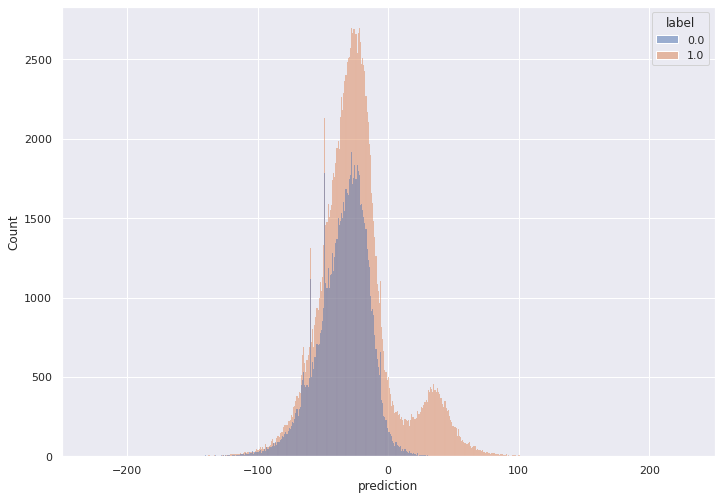

time: 6.56 s (started: 2022-01-24 15:39:44 +01:00)


In [62]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

sns.histplot(data=prediction_df, x="prediction", hue="label", ax=ax)

ax.set_xlim(-250, 250)
plt.show()

In [58]:
prediction_df["prediction"].min()

-1516.87158203125

time: 2.11 ms (started: 2022-01-24 15:38:07 +01:00)


In [59]:
prediction_df["prediction"].max()

401.1755676269531

time: 1.23 ms (started: 2022-01-24 15:38:15 +01:00)
